# **1. Instalação de Dependências**

In [21]:
#%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm river autorank

# **2. Importação de Bibliotecas de Análise**

In [22]:
from utils.FileManager import FileManager
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

from autorank import autorank, plot_stats, create_report
import matplotlib.pyplot as plt
from frameworkClasses.avaliador_framework import AvaliadorFramework

# **3. Importação de Avaliadores e Experimento**

In [23]:
from avaliacao.AvaliadorDriftBase import AvaliadorBatch
from avaliacao.AvaliadorDriftBase import AvaliadorPassivo
from experimento.ExperimentoDrift import Experimento
from preprocessamento.SeriesProcessor import SeriesProcessor

# **4. Importação de Detectores**

In [24]:
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

# **5. Importação de Modelos Offline**

In [25]:
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

# **6. Importação de Modelos Online**

In [26]:
from regressores.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from regressores.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from regressores.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from regressores.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# **7. Importação do Framework e Criação de Avaliador**

In [27]:
from frameworkDetector.framework_detector import FrameworkDetector
from utils.StreamProcessor import StreamProcessor
from avaliacao.AvaliadorDriftBase import AvaliadorDriftBase
from sklearn.metrics import mean_absolute_error

# **8. Lista de Séries Temporais**

In [28]:
series = [
    "AAPL",
    #"B3SA3.SA",
    #"^IXIC",
    #"^DJI",
    #"^GSPC",
    "^BVSP",
    #"USDBRL=X"
]

# **9. Parâmetros do Experimento**

In [29]:
tamanho_batch = 100
lags = 5
repeticoes = 5

# **10. Definição de Configuração do Framework**

In [30]:
framework_params_default = {
    'tipo_modelo_global': RandomForestModelo,
    'detector_cls': KSWINDetector,
    'detector_params': {'alpha': 0.05, 'window_size': 100},
    'tamanho_janela': 200,
    'intervalo_adicao_pool': 30,
    'observacoes_novo_conceito': 55,
    'max_pool_size': 5,
    'min_diversidade_erro': 0.05,
    'n_clusters_regimes': 5,
    'limiar_degradacao': 0.15,
    'threshold_melhoria_alerta': 0.94,
    'metrics_interval': 50,
    'min_samples_for_metrics': 5
}

In [31]:
fw_configs = [
    {
        'nome': "Framework_RF_KSWIN",
        'detector_cls': KSWINDetector,
        'detector_params': {'alpha': 0.05, 'window_size': 100}
    },
    {
        'nome': "Framework_RF_ADWIN",
        'detector_cls': ADWINDetector,
        'detector_params': {'delta': 0.002}
    },
    {
        'nome': "Framework_RF_HDDM_A",
        'detector_cls': HDDM_ADetector,
        'detector_params': {}
    },
    {
        'nome': "Framework_RF_DDM",
        'detector_cls': DDMDetector,
        'detector_params': {}
    }
]

# **11. Definição de Modelos para Comparação**

In [32]:
modelos_comparacao = []

# Adicionar diferentes configurações do framework
for config in fw_configs:
    # Criar uma cópia dos parâmetros padrão e atualizar com a configuração específica
    params = framework_params_default.copy()
    params.update({k: v for k, v in config.items() if k != 'nome'})

    modelos_comparacao.append({
        "nome": config['nome'],
        "avaliador": AvaliadorFramework(params),
        "modelo": None,  # O framework gerencia seus próprios modelos
        "detector": None  # O framework gerencia seus próprios detectores
    })

# Adicionar baselines: modelos offline + detector
for detector_cls in [KSWINDetector, ADWINDetector, HDDM_ADetector, DDMDetector]:
    detector_nome = detector_cls.__name__.replace("Detector", "")

    # Linear Regression + Detector
    modelos_comparacao.append({
        "nome": f"LR+{detector_nome}",
        "avaliador": AvaliadorBatch(),
        "modelo": LinearRegressionModelo,
        "detector": detector_cls
    })

    # Random Forest + Detector
    modelos_comparacao.append({
        "nome": f"RF+{detector_nome}",
        "avaliador": AvaliadorBatch(),
        "modelo": RandomForestModelo,
        "detector": detector_cls
    })

# Adicionar modelos online (sem detector)
modelos_online = [
    #HoeffdingTreeRegressorModelo,
    BayesianLinearRegressionModelo,
    KNNRegressorOnlineModelo,
    LinearRegressionOnlineModelo
]

for modelo_cls in modelos_online:
    modelos_comparacao.append({
        "nome": modelo_cls.__name__.replace("Modelo", ""),
        "avaliador": AvaliadorPassivo(),
        "modelo": modelo_cls,
        "detector": None
    })

# **12. Execução do Experimento**

In [33]:
print(f"Iniciando experimento com {len(modelos_comparacao)} modelos/estratégias, {len(series)} séries e {repeticoes} repetições...")

experimento = Experimento(
    series=series,
    modelos=modelos_comparacao,
    tamanho_batch=tamanho_batch,
    lags=lags,
    repeticoes=repeticoes
)

resultados_df = experimento.executar()

print("Experimento concluído!")

Iniciando experimento com 15 modelos/estratégias, 2 séries e 5 repetições...


[*********************100%***********************]  1 of 1 completed

Executando Framework_RF_KSWIN na série: AAPL
Ajustando Scaler nos dados iniciais...
✓ Scaler ajustado e aplicado.

Iniciando treinamento do modelo inicial: RandomForestModelo...
  ✅ Modelo RandomForestModelo treinado com sucesso

=== Iniciando Processamento do Stream ===
Processando 1152 amostras...


Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 2 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 0) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0104)
  Desempenho: atual=0.0104, melhor do pool=0.0104
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0104)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conc

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 2) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0100)
  Desempenho: atual=0.0100, melhor do pool=0.0100
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0100)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (Random

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 2) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0109)
  Desempenho: atual=0.0109, melhor do pool=0.0109
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0109)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (Random

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0087)
  Desempenho: atual=0.0087, melhor do pool=0.0087
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0087)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 4 → 0

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conc

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 1 → 3
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 3) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0079)
  Desempenho: atual=0.0079, melhor do pool=0.0079
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0079)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  ⚠️ Muda

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 1 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Degradação detectada (MAE: 0.2531)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.1119)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: R

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 3 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Degradação detectada (MAE: 0.2538)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.1134)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: R

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 1 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Degradação detectada (MAE: 0.2476)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.1081)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: R

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 4 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 0 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Degradação detectada (MAE: 0.2501)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.1098)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.109

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 2 → 1
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Degradação detectada (MAE: 0.2487)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.1082)
  Avaliando 1 modelos do pool na janel

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 326 (Detector: HDDM_ADetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0618)
  Desempenho: atual=0.0618, melhor do pool=0.0618
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0618)
  🔄 P

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 4 → 2

  ⚠️ Mudança de regime: 2 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 326 (Detector: HDDM_ADetector, Regime: 0) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0587)
  Desempenho: atual=0.0587, melhor do pool=0.0587
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor mode

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 1 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 323 (Detector: HDDM_ADetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0643)
  Desempenho: atual=0.0643, melhor do pool=0.0643
  Avaliando 1 modelos do pool na janela (200

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 2 → 3

  ⚠️ Mudança de regime: 3 → 2
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 2 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 328 (Detector: HDDM_ADetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0578)
  Desempenho: atual=0.0578, melh

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 2 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 4 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 0 → 3
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 326 (Detector: HDDM_ADetector, Regime: 1) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: Rando

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

!!! Drift detectado no índice 183 (Detector: DDMDetector, Regime: 3) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (183 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0076)
  Desempenho: atual=0.0076, melhor do pool=0.0076
  Avaliando 1 modelos do pool na janela (183 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0076)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 3 → 1

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.


Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 187 (Detector: DDMDetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (187 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0070)
  Desempenho: atual=0.0070, melhor do pool=0.0070
  Avaliando 1 modelos do pool na janela (187 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0070)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 4 → 0

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.


Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 3 → 1

!!! Drift detectado no índice 181 (Detector: DDMDetector, Regime: 1) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (181 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0064)
  Desempenho: atual=0.0064, melhor do pool=0.0064
  Avaliando 1 modelos do pool na janela (181 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0064)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 1 → 2

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestMode

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 3 → 4

!!! Drift detectado no índice 190 (Detector: DDMDetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (190 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0077)
  Desempenho: atual=0.0077, melhor do pool=0.0077
  Avaliando 1 modelos do pool na janela (190 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0077)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 4 → 2

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

--- Retreinando Modelo com 55 obs. do novo co

Stream:   0%|          | 0/1152 [00:00<?, ?it/s]

  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 188 (Detector: DDMDetector, Regime: 0) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (188 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0075)
  Desempenho: atual=0.0075, melhor do pool=0.0075
  Avaliando 1 modelos do pool na janela (188 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0075)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 4 → 0

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ⚠️ Modelo anterior descartado (não diverso)
  ✓ Novo model

[*********************100%***********************]  1 of 1 completed


Executando Framework_RF_KSWIN na série: ^BVSP
Ajustando Scaler nos dados iniciais...
✓ Scaler ajustado e aplicado.

Iniciando treinamento do modelo inicial: RandomForestModelo...
  ✅ Modelo RandomForestModelo treinado com sucesso

=== Iniciando Processamento do Stream ===
Processando 1139 amostras...


Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 2 → 1

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 1) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5378)
  Desempenho: atual=0.5378, melhor do pool=0.5378
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5378)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 1 → 0

  ⚠️ Mudança de regime: 0 → 1

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 2) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5240)
  Desempenho: atual=0.5240, melhor do pool=0.5240
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5240)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 1 → 2

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando n

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 3) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5367)
  Desempenho: atual=0.5367, melhor do pool=0.5367
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5367)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 3 → 0

  ⚠️ Mudança de regime: 0 → 4

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModel

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 2 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 3 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 4 → 3

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 3) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5276)
  Desempenho: atual=0.5276, melhor do pool=0.5276
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5276)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Nov

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 4 → 3

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 1 → 4

!!! Drift detectado no índice 200 (Detector: KSWINDetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5223)
  Desempenho: atual=0.5223, melhor do pool=0.5223
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5223)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para re

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Degradação detectada (MAE: 0.4390)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5291)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5291)
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

!!! Drift detectado no índice 228 (Detector: ADWINDetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.6921)
  Desempenho: atual=0.6921, melhor do pool=0.6921
  Avaliando 1 modelos do pool 

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 3 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 0 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Degradação detectada (MAE: 0.4369)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5215)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5215)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5215)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5215)
  

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 2 → 0
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 0 → 3

  ⚠️ Degradação detectada (MAE: 0.4309)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5064)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5064)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5064)
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

!!! Drift detectado no índice 228 (Detector: ADWINDetector, Regime

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 1 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 3 → 4
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Degradação detectada (MAE: 0.4448)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5410)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5410)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5410)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5410)
  

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 2 → 4

  ⚠️ Degradação detectada (MAE: 0.4379)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5266)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5266)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5266)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: Random

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

!!! Drift detectado no índice 151 (Detector: HDDM_ADetector, Regime: 2) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0811)
  Desempenho: atual=0.0811, melhor do pool=0.0811
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0811)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 2 → 4

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo anterior mantido no pool (diverso)
  ✓ Novo modelo 

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]

  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 151 (Detector: HDDM_ADetector, Regime: 0) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0825)
  Desempenho: atual=0.0825, melhor do pool=0.0825
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0825)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 3 → 0

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo anterior mantido no pool (diverso)
  ✓ Novo modelo 

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 151 (Detector: HDDM_ADetector, Regime: 2) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0811)
  Desempenho: atual=0.0811, melhor do pool=0.0811
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0811)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 2 → 4

  ⚠️ Mudança de regime: 4 → 2

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo anterior mantido no 

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 152 (Detector: HDDM_ADetector, Regime: 1) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (152 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0863)
  Desempenho: atual=0.0863, melhor do pool=0.0863
  Avaliando 1 modelos do pool na janela (152 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0863)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo anterior mantido no pool (diverso)
  ✓ Novo modelo ativo: 'RandomForestModelo'
---

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

!!! Drift detectado no índice 151 (Detector: HDDM_ADetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0833)
  Desempenho: atual=0.0833, melhor do pool=0.0833
  Avaliando 1 modelos do pool na janela (151 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0833)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 1 → 3

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
 

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 4 → 0

  ⚠️ Mudança de regime: 0 → 4

  ⚠️ Mudança de regime: 4 → 0

!!! Drift detectado no índice 200 (Detector: DDMDetector, Regime: 0) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5288)
  Desempenho: atual=0.5288, melhor do pool=0.5288
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5288)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 1 → 4

--- Retreinando Modelo com 55 obs. do novo conce

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]

  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  ⚠️ Degradação detectada (MAE: 0.4396)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5291)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5291)

  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

!!! Drift detectado no índice 234 (Detector: DDMDetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.7630)
  Desempenho: atual=0.7630, melhor do pool=0.7630
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.7630)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 am

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 2 → 4

  ⚠️ Mudança de regime: 4 → 2

  ⚠️ Mudança de regime: 2 → 4

  ⚠️ Degradação detectada (MAE: 0.4353)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5172)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5172)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5172)

  ⚠️ Mudança de regime: 4 → 0

!!! Drift detectado no índice 234 (Detector: DDMDetector, Regime: 0) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.7452)
  Desempenho: atual=0.7

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 2 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 3 → 2

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo

  ⚠️ Degradação detectada (MAE: 0.4448)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5391)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5391)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5391)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5391)

  ⚠️ Mudança de regime: 1 → 0

  ⚠️ Degradação detectada (MAE: 0.7536)
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecio

Stream:   0%|          | 0/1139 [00:00<?, ?it/s]


  🆕 Novo regime 4 detectado com modelo: RandomForestModelo

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹ️ Não adicionando modelo: similar a um existente e não melhor

  ⚠️ Mudança de regime: 1 → 4

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

  🆕 Novo regime 2 detectado com modelo: RandomForestModelo

  ⚠️ Mudança de regime: 2 → 4

!!! Drift detectado no índice 200 (Detector: DDMDetector, Regime: 4) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5246)
  Desempenho: atual=0.5246, melhor do pool=0.5246
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.5246)
  🔄 Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  ⚠️ Mudança de regime: 4 → 2

  ⚠️ Mudança de regime: 2 → 0

--- Retreinando Modelo com 55 obs. do novo conce

# **13. Salvamento dos Resultados**

In [34]:
arquivo_resultados = "framework_comparison_results.csv"
FileManager.salvar_resultados(resultados_df, arquivo_resultados)
print(f"Resultados salvos em {arquivo_resultados}")


Resultados salvos em: framework_comparison_results.csv
Resultados salvos em framework_comparison_results.csv


# **14. Carregamento dos Resultados para Análise**

In [35]:
df_results = pd.read_csv(arquivo_resultados)
print(f"Carregados {len(df_results)} registros de resultados")

Carregados 150 registros de resultados


# **15. Análise Agregada por Modelo e Séries**

In [36]:
summary = df_results.groupby(['serie', 'modelo']).agg(
    mae_mean=('mae', 'mean'),
    mae_std=('mae', 'std'),
    qtd_deteccoes_mean=('qtd_deteccoes', 'mean'),
    qtd_deteccoes_std=('qtd_deteccoes', 'std')
).reset_index()

print("\nResumo das Métricas:")
print(summary.head())


Resumo das Métricas:
  serie                    modelo   mae_mean   mae_std  qtd_deteccoes_mean  \
0  AAPL  BayesianLinearRegression   0.057742  0.000000                 NaN   
1  AAPL        Framework_RF_ADWIN   4.200000  0.447214                 NaN   
2  AAPL          Framework_RF_DDM   4.000000  0.000000                 NaN   
3  AAPL       Framework_RF_HDDM_A   3.000000  0.000000                 NaN   
4  AAPL        Framework_RF_KSWIN  11.000000  0.000000                 NaN   

   qtd_deteccoes_std  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  


# **16. Tabela de MAE médio por Modelo e Série**

In [37]:
print("\nMAE Médio por Modelo e Série:")
mae_mean_table = summary.pivot(index='serie', columns='modelo', values='mae_mean')
print(mae_mean_table)


MAE Médio por Modelo e Série:
modelo  BayesianLinearRegression  Framework_RF_ADWIN  Framework_RF_DDM  \
serie                                                                    
AAPL                    0.057742                 4.2               4.0   
^BVSP                   0.093285                 4.8               1.4   

modelo  Framework_RF_HDDM_A  Framework_RF_KSWIN  KNNRegressorOnline  LR+ADWIN  \
serie                                                                           
AAPL                    3.0                11.0            0.080643  0.060907   
^BVSP                   3.6                10.2            0.122306  0.119576   

modelo    LR+DDM  LR+HDDM_A  LR+KSWIN  LinearRegressionOnline  RF+ADWIN  \
serie                                                                     
AAPL    0.061505   0.060907  0.061927                0.077730  0.272581   
^BVSP   0.119576   0.119576  0.110193                0.118072  0.648299   

modelo    RF+DDM  RF+HDDM_A  RF+KSWIN  
serie 

# **17. Tabela de Desvio Padrão do MAE por Modelo e Série**

In [38]:
print("\nDesvio Padrão do MAE por Modelo e Série:")
mae_std_table = summary.pivot(index='serie', columns='modelo', values='mae_std')
print(mae_std_table)


Desvio Padrão do MAE por Modelo e Série:
modelo  BayesianLinearRegression  Framework_RF_ADWIN  Framework_RF_DDM  \
serie                                                                    
AAPL                         0.0            0.447214          0.000000   
^BVSP                        0.0            0.447214          0.547723   

modelo  Framework_RF_HDDM_A  Framework_RF_KSWIN  KNNRegressorOnline  LR+ADWIN  \
serie                                                                           
AAPL               0.000000            0.000000                 0.0       0.0   
^BVSP              0.547723            0.447214                 0.0       0.0   

modelo  LR+DDM  LR+HDDM_A  LR+KSWIN  LinearRegressionOnline  RF+ADWIN  \
serie                                                                   
AAPL       0.0        0.0  0.001969                     0.0  0.011816   
^BVSP      0.0        0.0  0.008049                     0.0  0.003068   

modelo    RF+DDM  RF+HDDM_A  RF+KSWIN  
ser

# **18. Tabela de Número Médio de Detecções por Modelo e Série**

In [39]:
print("\nNúmero Médio de Detecções por Modelo e Série:")
deteccoes_table = summary.pivot(index='serie', columns='modelo', values='qtd_deteccoes_mean')
print(deteccoes_table)


Número Médio de Detecções por Modelo e Série:
modelo  BayesianLinearRegression  Framework_RF_ADWIN  Framework_RF_DDM  \
serie                                                                    
AAPL                         NaN                 NaN               NaN   
^BVSP                        NaN                 NaN               NaN   

modelo  Framework_RF_HDDM_A  Framework_RF_KSWIN  KNNRegressorOnline  LR+ADWIN  \
serie                                                                           
AAPL                    NaN                 NaN                 NaN       0.0   
^BVSP                   NaN                 NaN                 NaN       0.0   

modelo  LR+DDM  LR+HDDM_A  LR+KSWIN  LinearRegressionOnline  RF+ADWIN  RF+DDM  \
serie                                                                           
AAPL       2.0        0.0       2.6                     NaN       2.0     1.6   
^BVSP      0.0        0.0       2.4                     NaN       3.0     1.4   

modelo

# **19. Preparação para Análise Estatística**

In [40]:
df_pivot_mae = df_results.pivot_table(index=["serie", "repeticao"], columns="modelo", values="mae")
df_pivot_mae = df_pivot_mae.dropna()  # Remove linhas com valores NaN

print("\nFormato dos dados para análise estatística:")
print(df_pivot_mae.head())


Formato dos dados para análise estatística:
modelo           BayesianLinearRegression  Framework_RF_ADWIN  \
serie repeticao                                                 
AAPL  1                          0.057742                 4.0   
      2                          0.057742                 4.0   
      3                          0.057742                 5.0   
      4                          0.057742                 4.0   
      5                          0.057742                 4.0   

modelo           Framework_RF_DDM  Framework_RF_HDDM_A  Framework_RF_KSWIN  \
serie repeticao                                                              
AAPL  1                       4.0                  3.0                11.0   
      2                       4.0                  3.0                11.0   
      3                       4.0                  3.0                11.0   
      4                       4.0                  3.0                11.0   
      5                       4

# **20. Análise Estatística com Autorank**


Executando análise estatística com autorank...
RankResult(rankdf=
                          meanrank     median       mad  ci_lower  ci_upper  \
modelo                                                                        
Framework_RF_KSWIN           15.00 -11.000000       0.0     -11.0     -10.0   
Framework_RF_ADWIN           13.75  -4.500000       0.5      -5.0      -4.0   
Framework_RF_DDM             12.70  -3.000000       1.0      -4.0      -1.0   
Framework_RF_HDDM_A          12.55  -3.000000       0.0      -4.0      -3.0   
RF+DDM                       10.30  -0.537944  0.129233 -0.959263 -0.408707   
RF+ADWIN                      9.50  -0.465440   0.18427  -0.65114 -0.261862   
RF+KSWIN                      9.20  -0.363935  0.035097 -0.433146  -0.32814   
RF+HDDM_A                     9.00  -0.368610  0.018063 -0.392551 -0.349811   
KNNRegressorOnline            7.00  -0.101474  0.020832 -0.122306 -0.080643   
LR+DDM                        4.70  -0.090541  0.029035 -0.11957

<Figure size 1200x800 with 0 Axes>

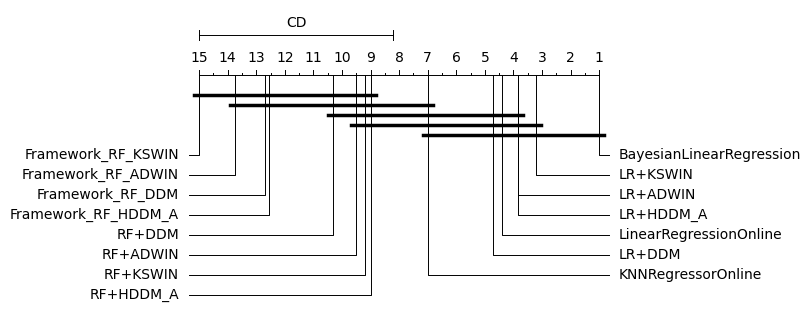

In [41]:
print("\nExecutando análise estatística com autorank...")

# Negativo porque autorank assume que valores maiores são melhores
# Para MAE, queremos minimizar
autorank_results = autorank(-df_pivot_mae, verbose=False)
print(autorank_results)

# Gerar relatório
create_report(autorank_results)

# Plotar resultados
plt.figure(figsize=(12, 8))
plot_stats(autorank_results, allow_insignificant=True)
plt.tight_layout()
plt.show()

# **21. Gráfico de Comparação de MAE Médio entre Modelos**

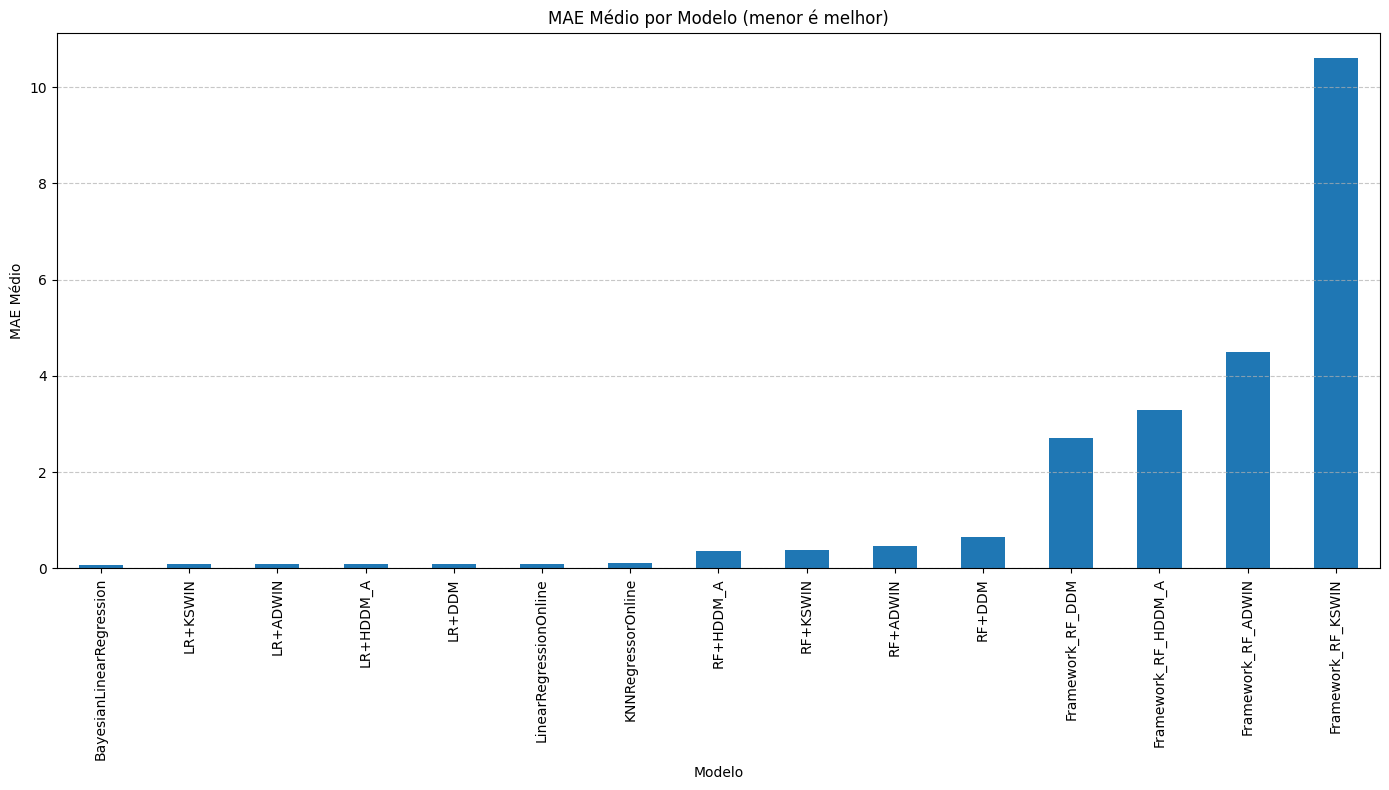

In [42]:
plt.figure(figsize=(14, 8))
mae_mean_series = summary.groupby('modelo')['mae_mean'].mean().sort_values()
mae_mean_series.plot(kind='bar')
plt.title('MAE Médio por Modelo (menor é melhor)')
plt.ylabel('MAE Médio')
plt.xlabel('Modelo')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **22. Gráfico de Número de Detecções por Modelo**

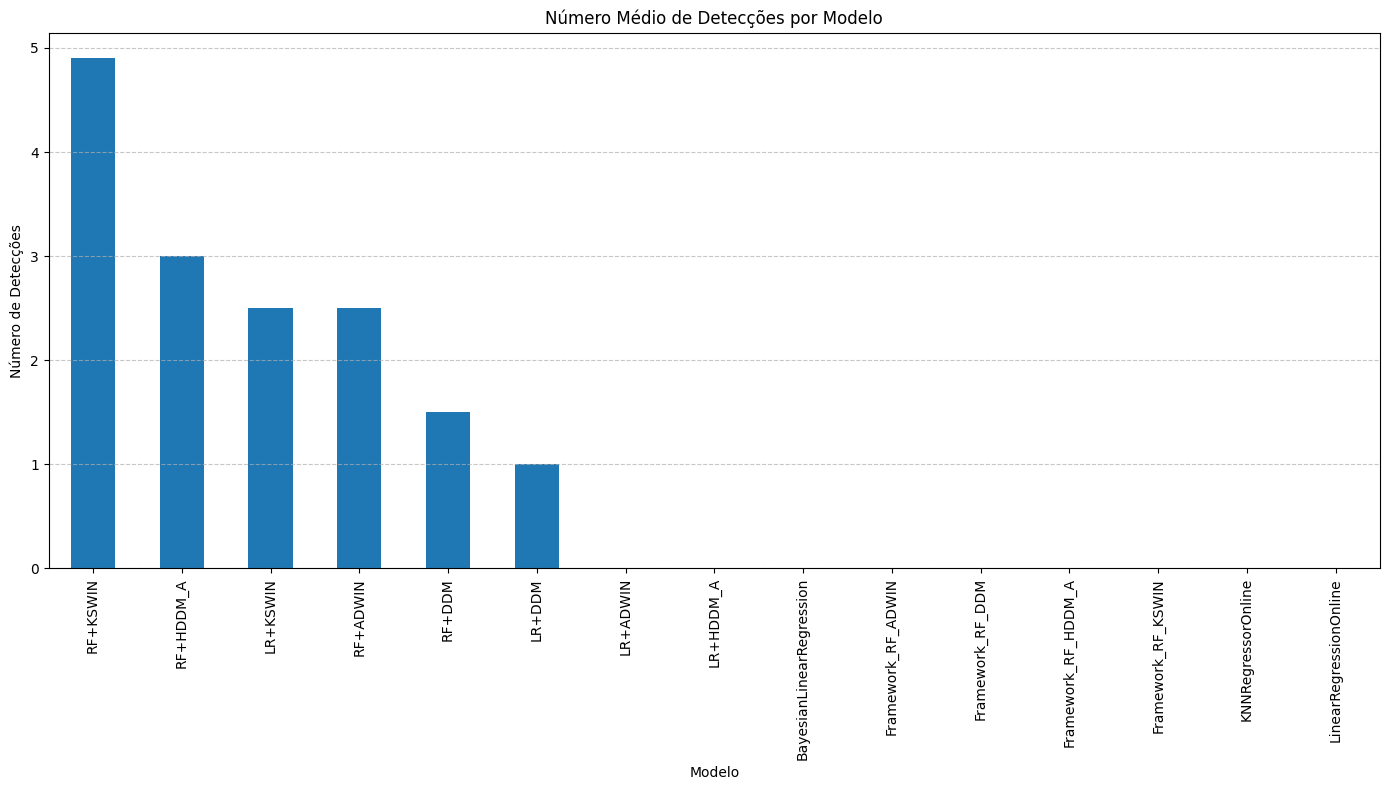

In [43]:
plt.figure(figsize=(14, 8))
detect_mean_series = summary.groupby('modelo')['qtd_deteccoes_mean'].mean().sort_values(ascending=False)
detect_mean_series.plot(kind='bar')
plt.title('Número Médio de Detecções por Modelo')
plt.ylabel('Número de Detecções')
plt.xlabel('Modelo')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()